In [100]:
import os
import os.path as osp
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import torch
import torchvision
from torch.utils import data
from PIL import Image


class SynaticDataSet(data.Dataset):
    def __init__(self, root, list_path, max_iters=None, crop_size=(321, 321), mean=(128, 128, 128), scale=True, mirror=True, ignore_label=255):
        self.root = root
        self.list_path = list_path
        self.crop_size = crop_size
        self.scale = scale
        self.ignore_label = ignore_label
        self.mean = mean
        self.is_mirror = mirror
        # self.mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
#         print(self.img_ids[:10])
        if not max_iters==None:
           self.img_ids = self.img_ids * int(np.ceil(float(max_iters) / len(self.img_ids)))
        self.files = []

        self.id_to_trainid = {0: 255, 1: 10, 2: 2, 3: 0, 4: 1, 5: 4,
                              6: 8, 7: 5, 8: 13, 9: 7, 10: 11, 11: 18, 12: 17,
                              13: 255, 14: 255, 15: 6, 16: 9, 17: 12, 18: 14, 19: 15, 20: 16, 21:3, 22:0}

        # for split in ["train", "trainval", "val"]:
        for name in self.img_ids:
            img_file = osp.join(self.root, "%s" % name)
            label_file = osp.join(self.root, "synthia_mapped_to_cityscapes/%s" % name.split('/')[-1])
#             print(img_file, label_file)
#             break
            self.files.append({
                "img": img_file,
                "label": label_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)


    def __getitem__(self, index):
        datafiles = self.files[index]

        image = Image.open(datafiles["img"]).convert('RGB')
        label = Image.open(datafiles["label"])
        name = datafiles["name"]
        
        # resize
        image = image.resize(self.crop_size, Image.BICUBIC)
        label = label.resize(self.crop_size, Image.NEAREST)

        image = np.asarray(image, np.float32)
        label = np.asarray(label, np.float32)
#         total = 0
#         for i in range(23):
#             total += np.sum(label==i)
#             print(np.sum(label==i))
#         print(total, label.shape)

        # re-assign labels to match the format of Cityscapes
        label_copy = 255 * np.ones(label.shape, dtype=np.float32)
        for k, v in self.id_to_trainid.items():
            label_copy[label == k] = v

        size = image.shape
        image = image[:, :, ::-1]  # change to BGR
#         image -= self.mean
        image = image.transpose((2, 0, 1))

        return image.copy(), label_copy.copy(), np.array(size), name


((512, 1024, 3), 255.0, 23.0)


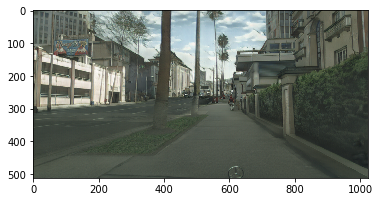

((512, 1024), 255.0, 0.0)


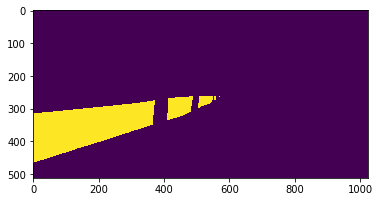

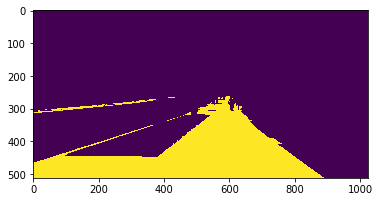

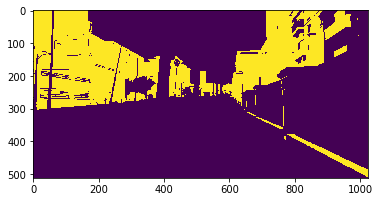

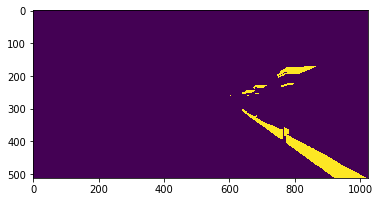

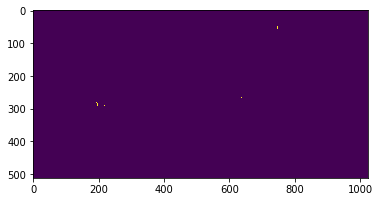

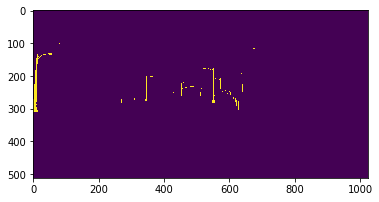

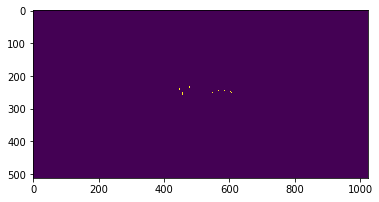

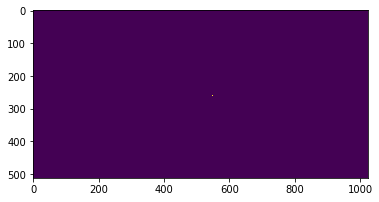

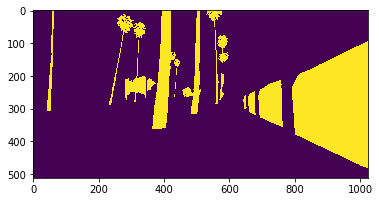

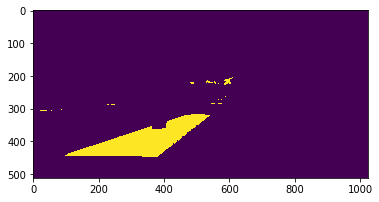

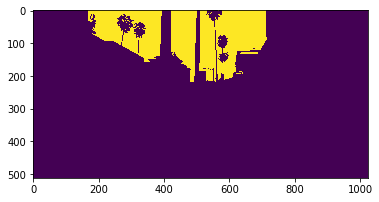

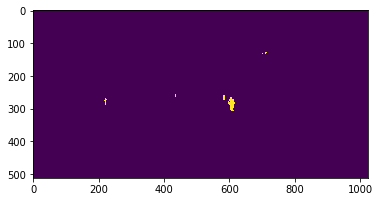

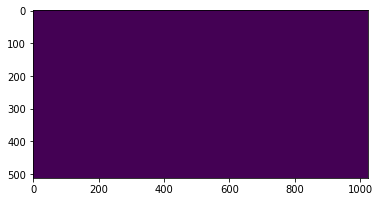

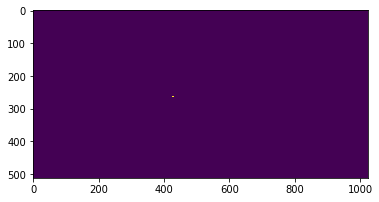

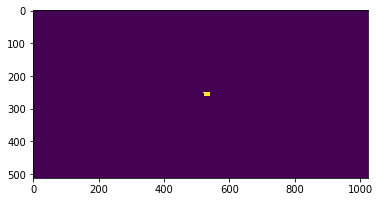

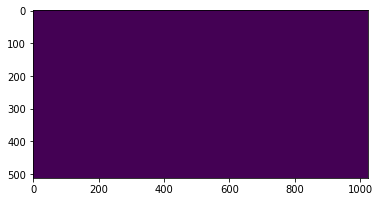

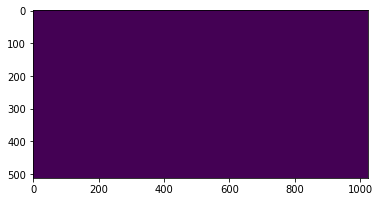

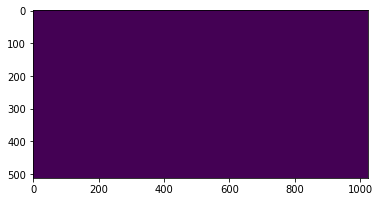

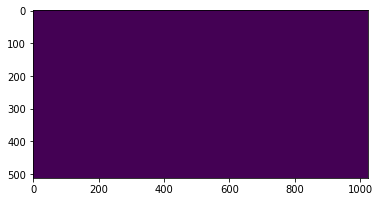

In [57]:
if __name__ == '__main__':
    dst = SynaticDataSet(root='/home/zhangjunyi/AdaptSegNet/data/cyclegta5', list_path = 'gta5_list/train.txt',
                        max_iters=100000,
                        crop_size=[1024, 512],
                        )
    
    trainloader = data.DataLoader(dst, batch_size=1,shuffle=True)
    for i, batch in enumerate(trainloader):
        imgs, labels, _, _ = batch
        img = imgs.data[0].detach().numpy()
        img = np.transpose(img, (1, 2, 0))
        print(img.shape, np.max(img), np.min(img))
        img = img[:, :, ::-1]
        plt.imshow(img/255)
        plt.show()
        label = labels.data[0].detach().numpy()
#         label = np.transpose(label, (1, 2, 0))
        print(label.shape, np.max(label), np.min(label))
        for i in range(19):
            output = np.zeros(label.shape)
            output[label==i] = 1
            plt.imshow(output)
            plt.show()
        break


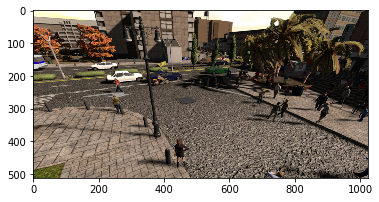

((512, 1024), 255.0, 0.0)


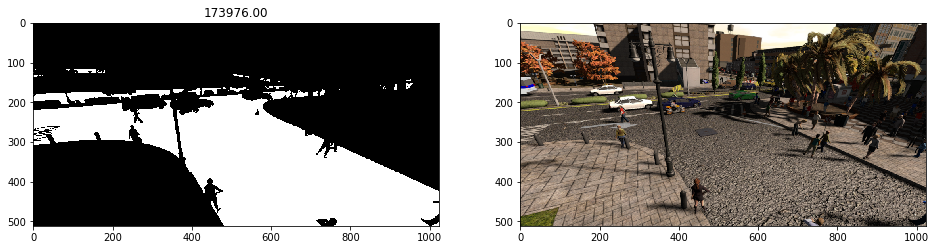

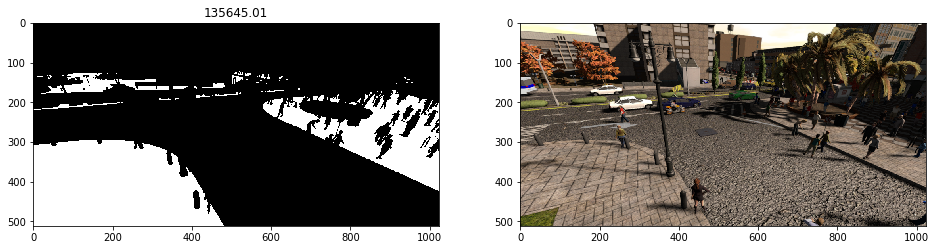

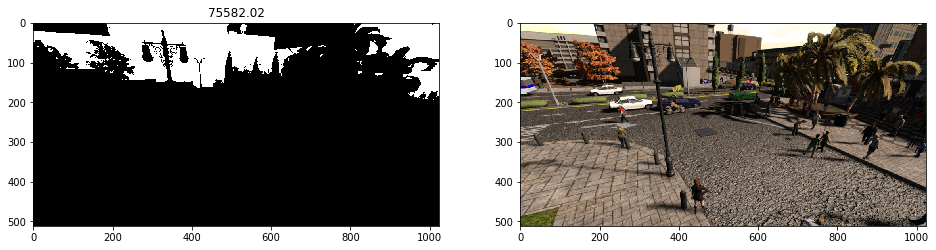

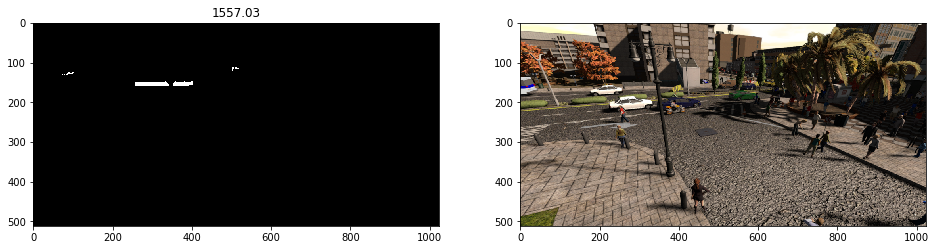

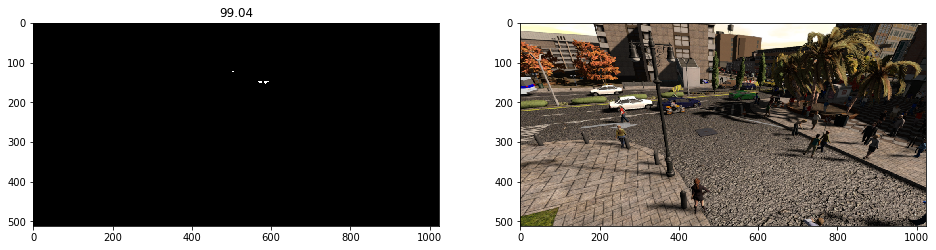

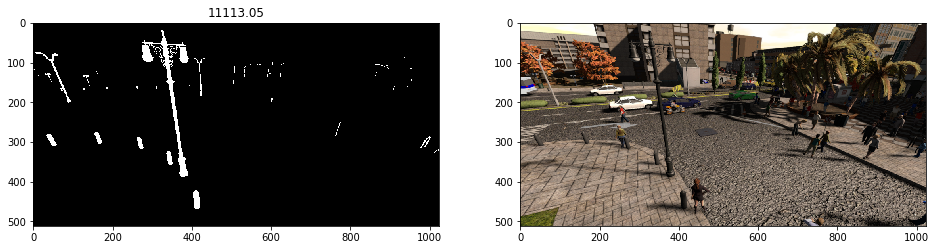

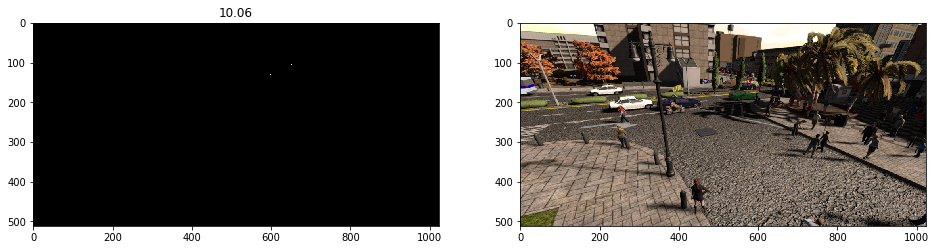

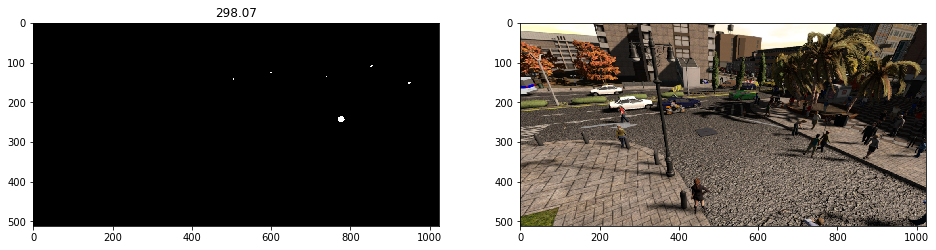

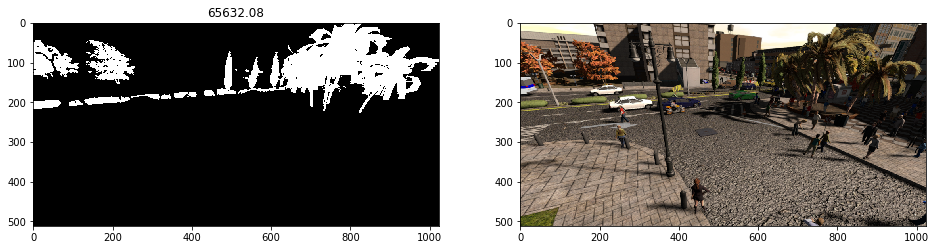

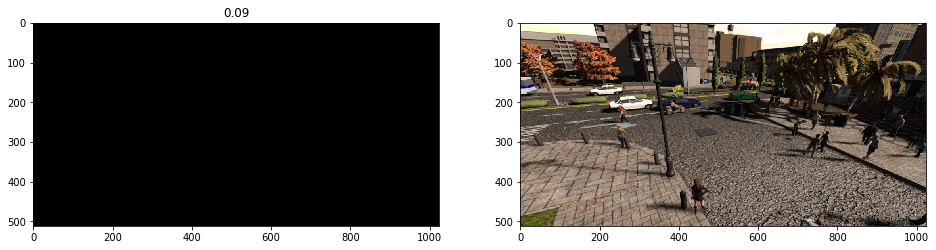

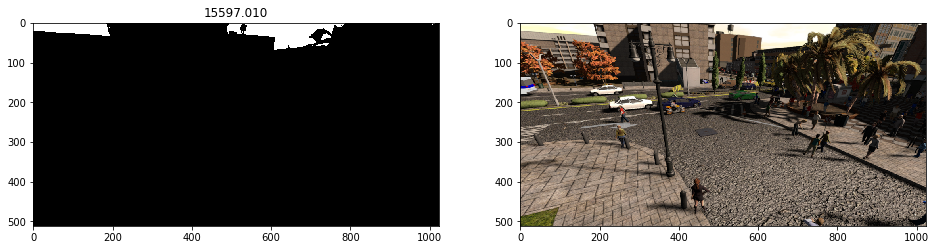

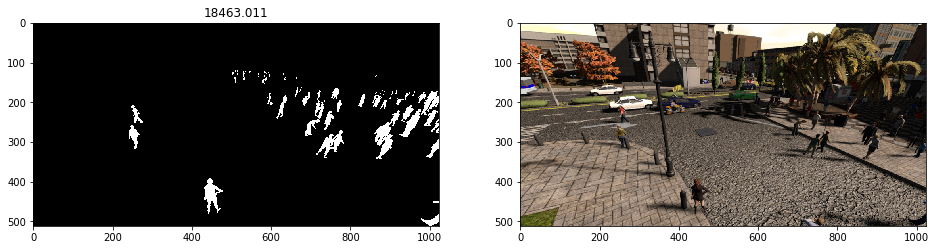

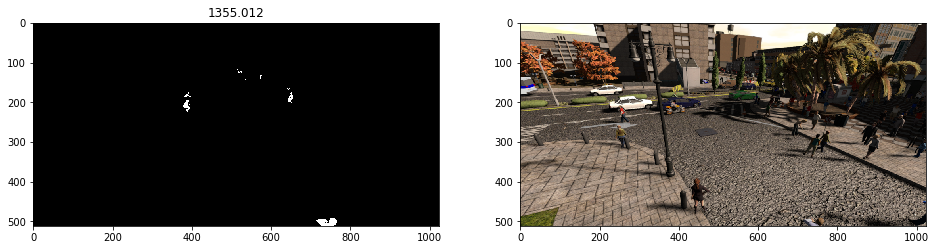

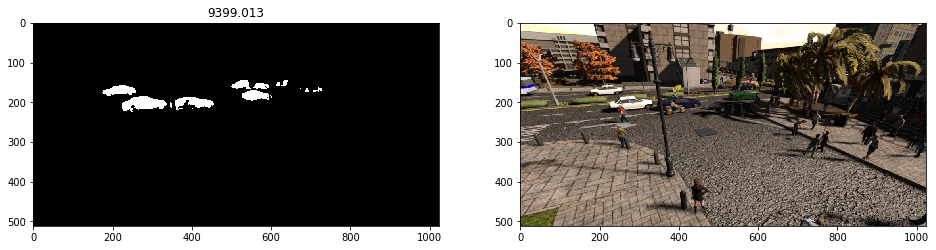

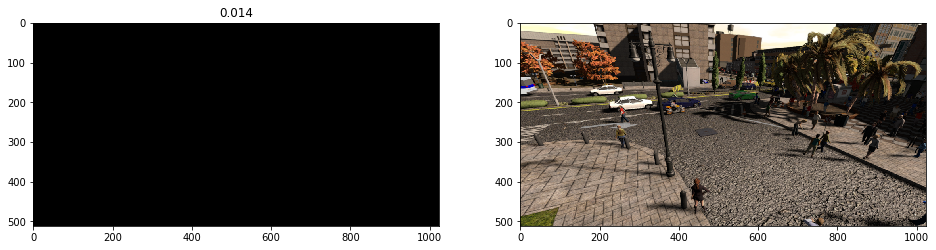

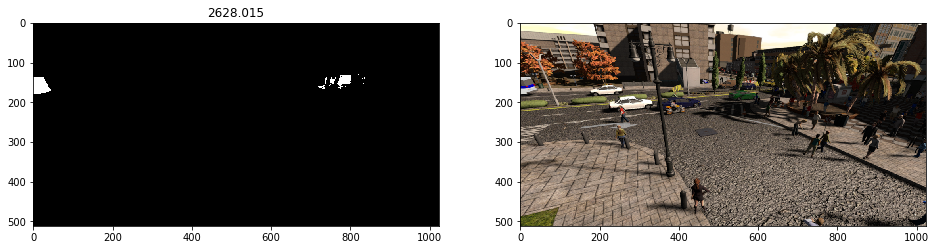

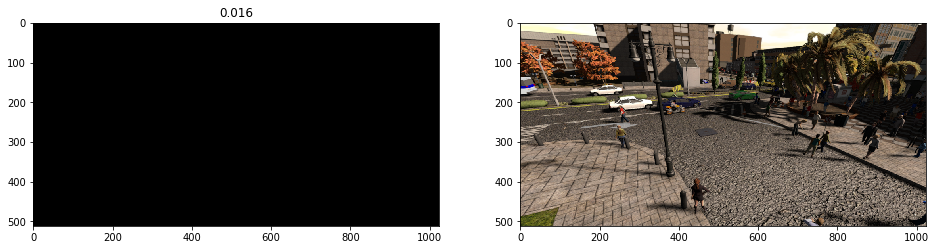

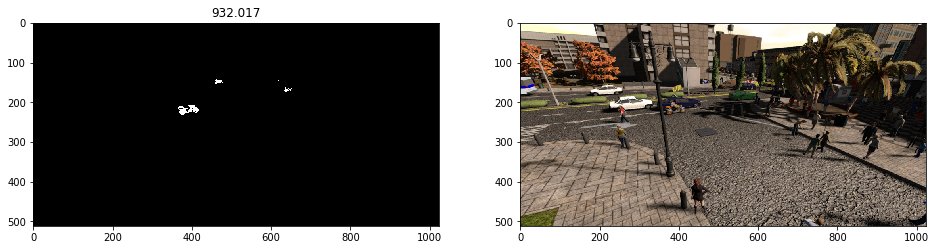

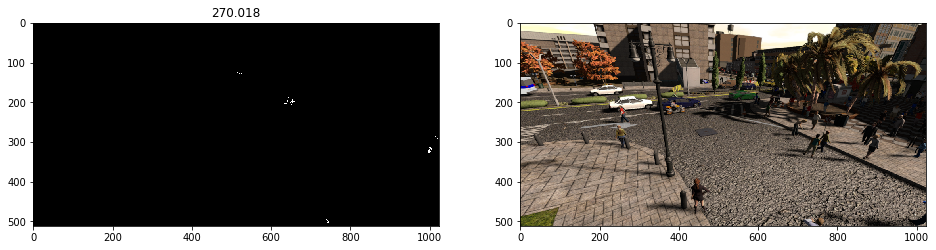

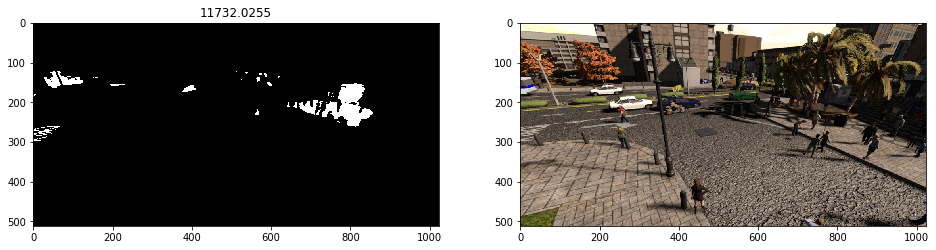

In [106]:
if __name__ == '__main__':
    dst = SynaticDataSet(root='/home/zhangjunyi/AdaptSegNet/data/RAND_CITYSCAPES', list_path = 'SYNTHIA_list/SYNTHIA_imagelist_train.txt',
                        max_iters=100000,
                        crop_size=[1024, 512],
                        )
    
    trainloader = data.DataLoader(dst, batch_size=1,shuffle=True)
    for i, batch in enumerate(trainloader):
        imgs, labels, _, _ = batch
        img = imgs.data[0].detach().numpy()
        label = labels.data[0].detach().numpy()
        img = np.transpose(img, (1, 2, 0))
#         label[label==255] = 0
#         print(np.max(label))
#         print(img.shape, np.max(img), np.min(img))
        img = img[:, :, ::-1]
        plt.imshow(img/255)
        plt.show()
        
#         label = np.transpose(label, (1, 2, 0))
        print(label.shape, np.max(label), np.min(label))
        for i in [i for i in range(19)]+[255]:
            output = np.zeros(label.shape)
            output[label==i] = 1
            plt.figure(figsize=(16, 32))
            plt.subplot(121)
            plt.title(str(np.sum(output[label==i]))+str(i))
            plt.imshow(output, cmap='gray')
            plt.subplot(122)
            plt.imshow(img/255, cmap='gray')
            plt.show()
        break
